In [ ]:
import json
import pandas as pd
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt
import math
from statistics import NormalDist
import numpy as np


@dataclass
class Trade:
    timestamp: int
    buyer: str
    seller: str
    symbol: str
    currency: str
    price: float
    quantity: int

# # Read entire log file
# with open('/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round3/eda/round3_results/round_3_results.log', 'r') as f:
#     content = f.read()

# # --- Parse Sandbox Logs ---
# sandbox_start = content.find('Sandbox logs:')
# activities_start = content.find('Activities log:')
# sandbox_section = content[sandbox_start + len('Sandbox logs:'):activities_start].strip()

# # Each JSON object is on a new line; wrap in array brackets
# # sandbox_json = '[' + ','.join(sandbox_section.split('\n')) + ']'

# # sandbox_logs = json.loads(sandbox_json)

# # --- Parse Activities Log ---
# trades_start = content.find('Trade History:')
# activities_section = content[activities_start + len('Activities log:'):trades_start].strip()

# # Read CSV section into a DataFrame
# from io import StringIO
# activities_df = pd.read_csv(StringIO(activities_section), sep=';')

# # --- Parse Trades ---
# trades_section = content[trades_start + len('Trade History:'):].strip()
# trades_data = json.loads(trades_section)

# # Convert to Trade objects
# trades: List[Trade] = [Trade(**t) for t in trades_data]

In [26]:
day_price_1_df = pd.read_csv("./round-4-island-data-bottle/prices_round_4_day_1.csv", delimiter=";")
day_price_2_df = pd.read_csv("./round-4-island-data-bottle/prices_round_4_day_2.csv", delimiter=";")
day_price_3_df = pd.read_csv("./round-4-island-data-bottle/prices_round_4_day_3.csv", delimiter=";")

# merge all the dataframes
activities_df = pd.concat([day_price_1_df, day_price_2_df, day_price_3_df])
activities_df["continuous_timestamp"] = activities_df["day"] * 1e6 + activities_df["timestamp"]
activities_df

symbols = [
    # "RAINFOREST_RESIN",
    # "KELP", "SQUID_INK",
    # "CROISSANTS", "JAMS",
    # "DJEMBES", "PICNIC_BASKET1",
    # "PICNIC_BASKET2",
    "VOLCANIC_ROCK",
    "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500"
]

In [27]:
activities_df['spread'] = activities_df["ask_price_1"] - activities_df["bid_price_1"]
volcanic_rock_voucher_df = activities_df[activities_df["product"].str.contains("VOLCANIC_ROCK_VOUCHER")].copy()
volcanic_rock_df = activities_df[activities_df["product"] == "VOLCANIC_ROCK"].copy()

In [38]:
def black_scholes_implied_vol(St, Vt, K, TTE, tol=1e-8, max_iter=50):
    if St <= 0 or K <= 0 or TTE <= 0 or Vt <= 0:
        return float('nan')
    
    wrong = 0
    
    N = NormalDist()
    sigma = 0.2
    for _ in range(max_iter):
        iteration = _
        d1 = (math.log(St / K) + 0.5 * sigma**2 * TTE) / (sigma * math.sqrt(TTE))
        d2 = d1 - sigma * math.sqrt(TTE)
        price = St * N.cdf(d1) - K * N.cdf(d2)
        vega = St * N.pdf(d1) * math.sqrt(TTE)
        diff = price - Vt
        if vega < 1e-8:
            return fallback_bisection_iv(St, Vt, K, TTE)
        if abs(diff) < tol:
            # print(f"Iteration {iteration}: Converged with sigma = {sigma}")
            if sigma < 0 or sigma > 2:
                wrong += 1
                print(f"Iteration {iteration}: Sigma out of bounds, returning 0")
                print(f"vega: {vega}, diff: {diff}, St: {St}, K: {K}, TTE: {TTE}, Vt: {Vt}, price: {price}")
                return 0
            return sigma
        sigma -= diff / vega
    # print(f"Iteration {iteration}: Max iterations reached with sigma = {sigma}")
    if sigma < 0 or sigma > 2:
        wrong += 1
        print(f"Iteration {iteration}: Sigma out of bounds, returning 0")
        print(f"vega: {vega}, diff: {diff}, St: {St}, K: {K}, TTE: {TTE}, Vt: {Vt}, price: {price}")
        return 0
    print(f"wrong: {wrong}")
    return sigma


volcanic_rock_df = activities_df[activities_df["product"] == "VOLCANIC_ROCK"].copy()

def fallback_bisection_iv(St, Vt, K, TTE, low=1e-4, high=3.0, tol=1e-4):
    N = NormalDist()
    for _ in range(10):
        mid = (low + high) / 2
        d1 = (math.log(St/K) + 0.5 * mid**2 * TTE) / (mid * math.sqrt(TTE))
        d2 = d1 - mid * math.sqrt(TTE)
        price = St * N.cdf(d1) - K * N.cdf(d2)
        if abs(price - Vt) < tol:
            return mid
        if price > Vt:
            high = mid
        else:
            low = mid
    return mid  # last try

def calculate_tte(timestamp, day):
    return ((7 - day) * 1e6 - timestamp) / (1e6 * 365)

def get_mid_price_at_timestamp(timestamp):
    row = volcanic_rock_df[volcanic_rock_df["timestamp"] == timestamp]
    if not row.empty:
        return row["mid_price"].iloc[0]
    return None

volcanic_rock_voucher_df["implied_volatility"] = volcanic_rock_voucher_df.apply(
    lambda row: black_scholes_implied_vol(
        St=get_mid_price_at_timestamp(row["timestamp"]),
        Vt=row["mid_price"],
        K=float(row["product"].split("_")[-1]),
        TTE=calculate_tte(row["timestamp"], row["day"])
    ) if get_mid_price_at_timestamp(row["timestamp"]) is not None else None,
    axis=1
)

volcanic_rock_voucher_df["moneyness"] = volcanic_rock_voucher_df.apply(
    lambda row: math.log(float(row["product"].split("_")[-1]) / get_mid_price_at_timestamp(row["timestamp"]))
    / math.sqrt(calculate_tte(row["timestamp"], row["day"]))
    if get_mid_price_at_timestamp(row["timestamp"]) is not None else None,
    axis=1
)

# Function to fit a quadratic and calculate fitted volatility
def fit_quadratic_and_calculate_fitted_iv(df):
    fitted_volatilities = []

    # Group by each timestep
    for timestamp, group in df.groupby("timestamp"):
        # Extract moneyness and implied volatility
        moneyness = group["moneyness"].values
        iv = group["implied_volatility"].values

        # Fit a quadratic if there are enough points
        if len(moneyness) >= 3:
            coeffs = np.polyfit(moneyness, iv, 2)
            # Calculate fitted volatility using the quadratic
            fitted_iv = np.polyval(coeffs, moneyness)
            base_iv = coeffs[2]
        else:
            # If not enough points, use NaN
            fitted_iv = [np.nan] * len(moneyness)

        # Append the fitted volatilities
        fitted_volatilities.extend(fitted_iv)

    return fitted_volatilities, base_iv

# Apply the function to calculate fitted volatilities

fitted = fit_quadratic_and_calculate_fitted_iv(volcanic_rock_voucher_df)
volcanic_rock_voucher_df["fitted_volatility"] = fitted[0]
volcanic_rock_voucher_df["base_iv"] = fitted[1]

wrong: 0
Iteration 49: Sigma out of bounds, returning 0
vega: 27.528398897971353, diff: -64.80599754546976, St: 10515.5, K: 10250.0, TTE: 0.013696438356164383, Vt: 64.5, price: -0.305997545469765
wrong: 0
wrong: 0
Iteration 49: Sigma out of bounds, returning 0
vega: 218.4639763195609, diff: 2.437660775767654, St: 10511.5, K: 10500.0, TTE: 0.013675890410958904, Vt: 9.5, price: 11.937660775767654
wrong: 0
Iteration 49: Sigma out of bounds, returning 0
vega: 61.47374578796593, diff: -201.5116099771831, St: 10507.5, K: 10000.0, TTE: 0.013453698630136986, Vt: 199.5, price: -2.011609977183099
Iteration 49: Sigma out of bounds, returning 0
vega: 61.638842790254394, diff: -201.52209524441648, St: 10508.0, K: 10000.0, TTE: 0.013453424657534246, Vt: 199.5, price: -2.0220952444164766
Iteration 49: Sigma out of bounds, returning 0
vega: 56.92667464332557, diff: -202.28307491740796, St: 10507.5, K: 10000.0, TTE: 0.013453150684931506, Vt: 200.5, price: -1.7830749174079585
Iteration 49: Sigma out of 

In [39]:
volcanic_rock_voucher_df.loc[volcanic_rock_voucher_df['implied_volatility'] > 2, 'implied_volatility'] = 0
strike_dfs = {strike: volcanic_rock_voucher_df[volcanic_rock_voucher_df['product'] == f"VOLCANIC_ROCK_VOUCHER_{strike}"] for strike in range(9500, 10501, 250)}


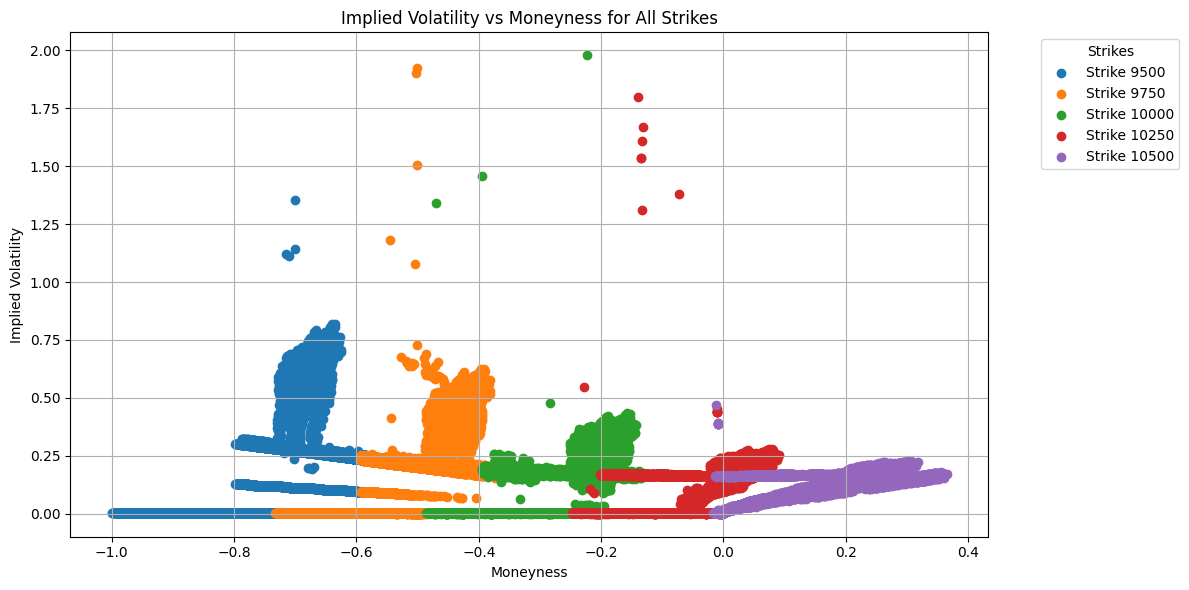

In [40]:
plt.figure(figsize=(12, 6))

for strike, df in strike_dfs.items():
    plt.scatter(df['moneyness'], df['implied_volatility'], label=f'Strike {strike}')

plt.title('Implied Volatility vs Moneyness for All Strikes')
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.legend(title='Strikes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

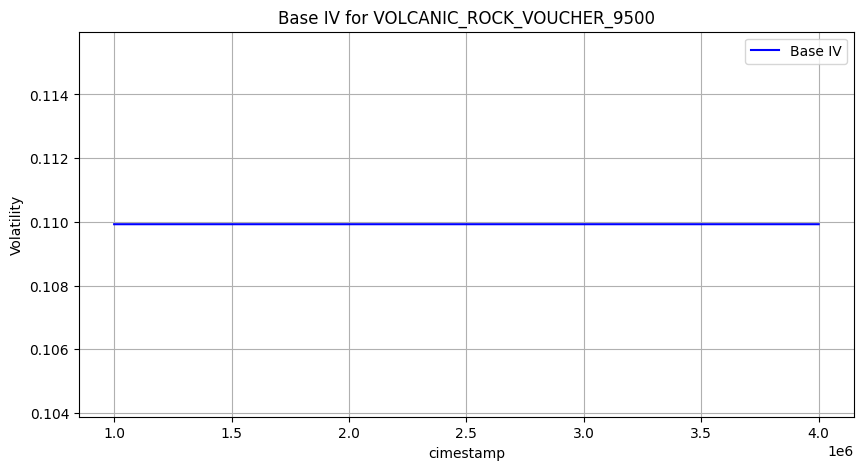

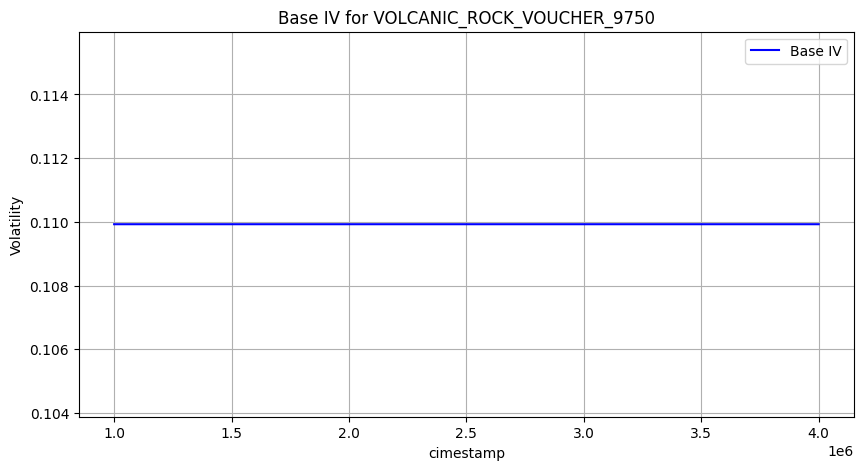

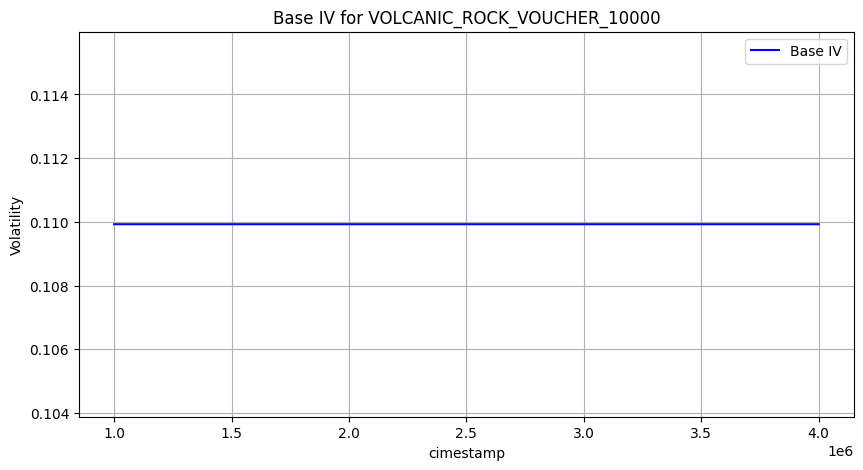

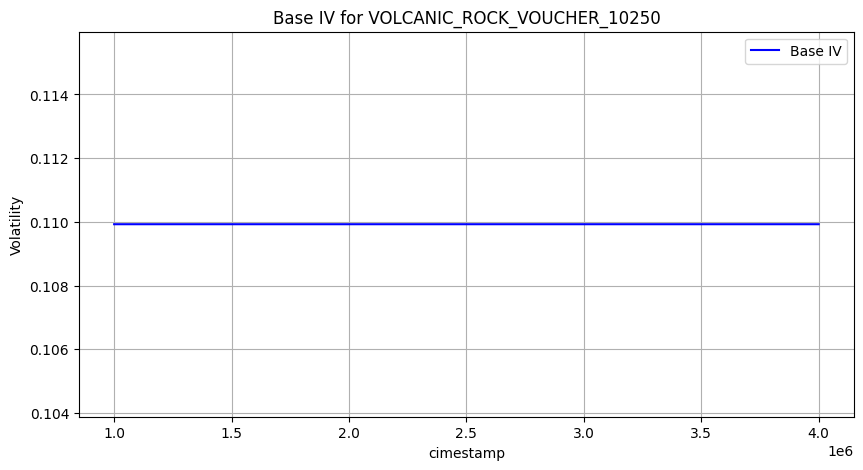

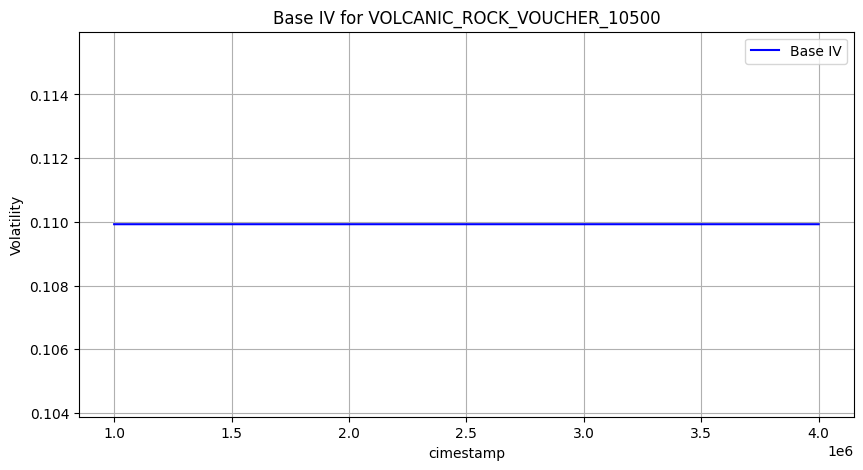

In [41]:
for strike, df in strike_dfs.items():
    plt.figure(figsize=(10, 5))
    plt.plot(df['continuous_timestamp'], df['base_iv'], label='Base IV', color='blue')
    plt.title(f'Base IV for VOLCANIC_ROCK_VOUCHER_{strike}')
    plt.xlabel('cimestamp')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid()
    plt.show()